In [1]:
import sys

sys.path.append('/home/caihuaiguang/DSG/pytorch-shapley-cam')

# 验证路径是否已添加
print(sys.path)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"  # 将 "0" 替换为你想指定的 GPU ID



['/media/caihuaiguang/miniconda3/envs/cords/lib/python38.zip', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/lib-dynload', '', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages', '/home/caihuaiguang/DSG/InfoBatch', '/home/caihuaiguang/DSG/pytorch-shapley-cam']


In [2]:
# import warnings
# warnings.filterwarnings('ignore')
from torchvision import models
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import timm
import cv2
import torch
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image, undo_preprocess_image
from PIL import Image
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage, ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget, ClassifierOutputLnSoftmaxTarget,  ClassifierOutputEntropy, ClassifierOutputReST, ClassifierOutputResidualSoftmaxTarget
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.metrics.ADCC import ADCC
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenGradCAM, LayerCAM, AblationCAM, RandomCAM, ShapleyCAM, ShapleyCAM_mean, ShapleyCAM_hires, GradCAMElementWise, HiResCAM, XGradCAM


In [3]:
# # vit performance is not good
# import torch
# def reshape_transform(tensor, height=14, width=14):
#     # print(tensor.shape)
#     result = tensor[:, 1:, :].reshape(tensor.size(0),
#                                       height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result
# model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

# target_layers =  [model.blocks[-1].norm1]
# # target_layers =  [model.blocks[-1].norm2]
# # target_layers =  [model.norm]

In [4]:
# def reshape_transform(result, height=7, width=7):
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# # target_layers = [model.layers[-1].blocks[-1].norm1]
# target_layers = [model.norm]

In [5]:
# def reshape_transform(result, height=7, width=7):
#     result = result.reshape(result.size(0),
#                             height, width, result.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# target_layers = [model.layers[-1].blocks[-1].norm2]

In [6]:

# model = models.resnet101(pretrained=True)
# reshape_transform = None
# target_layers = [model.layer4[-2].conv3]

In [7]:

# model = models.resnet18(pretrained=True)
# reshape_transform = None
# # target_layers = [model.layer4[-1].conv2]
# # target_layers = [model.layer4[-1].relu]
# target_layers = [model.layer4[-1]]

In [8]:

# model = models.efficientnet_b0(pretrained=True)
# reshape_transform = None
# target_layers = [model.features[8][0]]

In [9]:

# model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
# reshape_transform = None
# target_layers = [model.features[-1][0]]
# # print(model.features[8])

In [10]:
model = models.vgg16(pretrained=True)
reshape_transform = None
target_layers = [model.features[-3]]

/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model.eval()
model = model.cuda()

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, name, adcc):
    visualization = cv2.putText(visualization, name, (5, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    if adcc is not None:
        visualization = cv2.putText(visualization, f"{adcc:.5f}", (150, 20), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(_img_example, _image_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=None):
    methods = [("ShapleyCAM", ShapleyCAM_mean(model=model, target_layers=target_layers, reshape_transform=reshape_transform))]

    cam_metric = ADCC()
    # targets = [ClassifierOutputTarget(category)]
    # targets = [ClassifierOutputSoftmaxTarget(category)]
    # targets = [ClassifierOutputLnSoftmaxTarget(category)]
    # targets = [ClassifierOutputEntropy(category)]
    targets = [ClassifierOutputReST(category)]
    # targets = [ClassifierOutputResidualSoftmaxTarget(category)]
    
    
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    # visualizations = [visualize_score(np.uint8(_img_example*255), _image_name, None)]
    visualizations = []
    for name, cam_method in methods:
        attributions = cam_method(input_tensor=input_tensor, 
                                    targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]   
        adcc, avg_drop, coherency, complexity, inc, dropindeletion, only, delete   =cam_metric(input_tensor,attributions,targets,metric_targets,model, cam_method, return_visualization=True)
        visualization = show_cam_on_image(_img_example, attribution, use_rgb=True)
        # visualization = visualize_score(visualization, name, adcc[0])
        print(visualization.shape)
        print(only.shape)
        explanation_map = undo_preprocess_image(only[0].cpu())
        anti_explanation_map = undo_preprocess_image(delete[0].cpu())
        # can not execute correctly
        # explanation_map = deprocess_image(only[0].cpu().numpy().transpose((1, 2, 0)))
        # anti_explanation_map = deprocess_image(delete[0].cpu().numpy().transpose((1, 2, 0)))
        # explanation_map =  visualize_score(explanation_map, "anti explanation map", None)
        # anti_explanation_map =  visualize_score(anti_explanation_map, "anti explanation map", None)
        visualizations.append(explanation_map)
        visualizations.append(visualization)
        visualizations.append(anti_explanation_map)

    return Image.fromarray(np.hstack(visualizations))


In [12]:
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
# using this link to get label name from ID (start from 0) 

29
(224, 224, 3)
torch.Size([1, 3, 224, 224])


/home/caihuaiguang/DSG/pytorch-shapley-cam/pytorch_grad_cam/metrics/ADCC.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = attr_method(torch.tensor(explanation_map), targets)


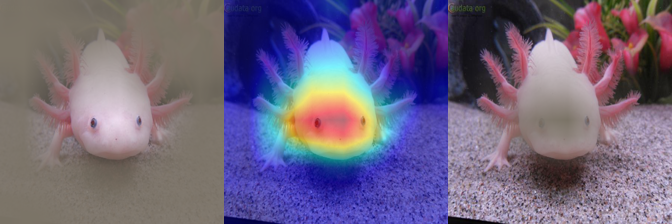

In [13]:
img_example = np.array(Image.open("pic/ILSVRC2012_val_00022113.JPEG"))
category = 29 # 	axolotl
img_name = "axolotl"

img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
outputs = model(input_tensor)
_, predicted_category = torch.max(outputs.data, 1)
predicted_category = predicted_category.item()
print(predicted_category)
benchmark(img_example, img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= predicted_category)

24
(224, 224, 3)
torch.Size([1, 3, 224, 224])


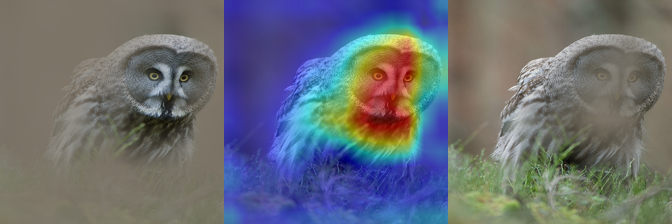

In [14]:
img_example = np.array(Image.open("pic/ILSVRC2012_val_00000318.JPEG"))
category = 24 # 	great grey owl
img_name = "great grey owl"

img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
outputs = model(input_tensor)
_, predicted_category = torch.max(outputs.data, 1)
predicted_category = predicted_category.item()
print(predicted_category)
benchmark(img_example, img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= predicted_category)

9


(224, 224, 3)
torch.Size([1, 3, 224, 224])


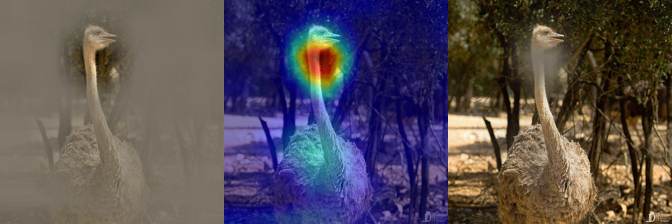

In [15]:
img_example = np.array(Image.open("pic/ILSVRC2012_val_00019184.JPEG"))
category = 9 # 	ostrich
img_name = "ostrich"

img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
outputs = model(input_tensor)
_, predicted_category = torch.max(outputs.data, 1)
predicted_category = predicted_category.item()
print(predicted_category)
benchmark(img_example, img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= predicted_category)

992
(224, 224, 3)
torch.Size([1, 3, 224, 224])


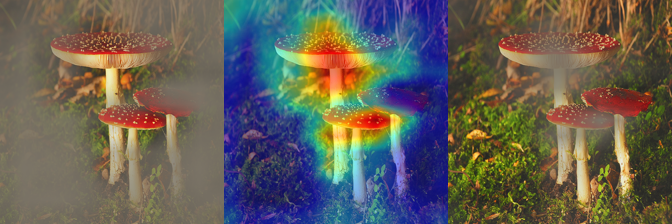

In [16]:
img_example = np.array(Image.open("pic/ILSVRC2012_val_00005745.JPEG"))
category = 992 # 	agaric
img_name = "agaric"

img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
outputs = model(input_tensor)
_, predicted_category = torch.max(outputs.data, 1)
predicted_category = predicted_category.item()
print(predicted_category)
benchmark(img_example, img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= predicted_category)

90


(224, 224, 3)
torch.Size([1, 3, 224, 224])


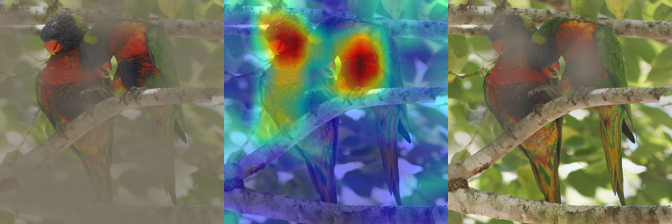

In [17]:
img_example = np.array(Image.open("pic/ILSVRC2012_val_00028570.JPEG"))
category = 90 # 	lorikeet
img_name = "lorikeet"

img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
outputs = model(input_tensor)
_, predicted_category = torch.max(outputs.data, 1)
predicted_category = predicted_category.item()
print(predicted_category)
benchmark(img_example, img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= predicted_category)

23


(224, 224, 3)
torch.Size([1, 3, 224, 224])


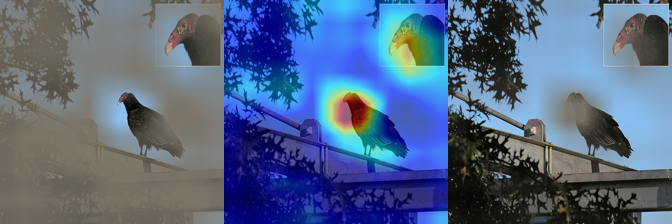

In [18]:
img_example = np.array(Image.open("pic/ILSVRC2012_val_00012615.JPEG"))
category = 23 # 	vulture
img_name = "vulture"

img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
outputs = model(input_tensor)
_, predicted_category = torch.max(outputs.data, 1)
predicted_category = predicted_category.item()
print(predicted_category)
benchmark(img_example, img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= predicted_category)

0
(224, 224, 3)
torch.Size([1, 3, 224, 224])


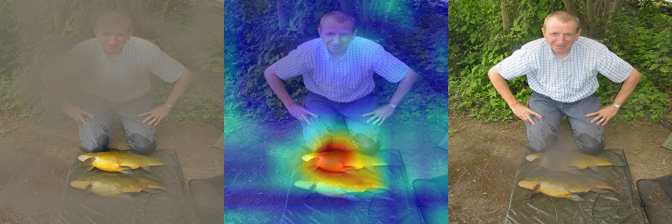

In [19]:
img_example = np.array(Image.open("pic/ILSVRC2012_val_00041939.JPEG"))
category = 0 # 	tench
img_name = "tench"

img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
outputs = model(input_tensor)
_, predicted_category = torch.max(outputs.data, 1)
predicted_category = predicted_category.item()
print(predicted_category)
benchmark(img_example, img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= predicted_category)

282


(224, 224, 3)
torch.Size([1, 3, 224, 224])


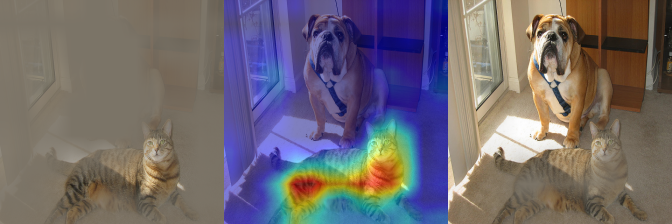

In [20]:
img_example = np.array(Image.open("../examples/both.png")) 
predicted_category = 282 # tiger cat

img_name = "tiger cat"

img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
# outputs = model(input_tensor)
# _, predicted_category = torch.max(outputs.data, 1)
# predicted_category = predicted_category.item()
print(predicted_category)
benchmark(img_example, img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= predicted_category)

242
(224, 224, 3)
torch.Size([1, 3, 224, 224])


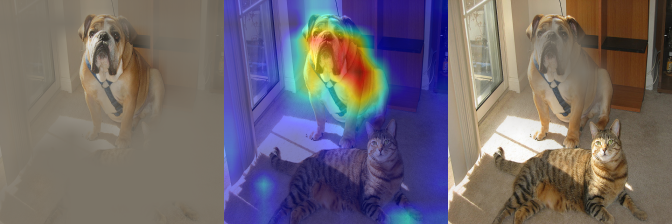

In [21]:
img_example = np.array(Image.open("../examples/both.png")) 
predicted_category = 242 # boxer

img_name = "boxer"

img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
# outputs = model(input_tensor)
# _, predicted_category = torch.max(outputs.data, 1)
# predicted_category = predicted_category.item()
print(predicted_category)
benchmark(img_example, img_name, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= predicted_category)